# DeepONet for 1D Diffusion Equation

This notebook demonstrates the use of a Deep Operator Network (DeepONet) to solve a 1D diffusion equation. The DeepONet is a neural network architecture designed to learn operators, which are mappings between function spaces. In this case, the DeepONet learns the operator that maps the initial condition of the diffusion equation to the solution at a later time.

In [22]:
import torch
import numpy as np

# Set random seeds for reproducibility
np.random.seed(89757)
torch.manual_seed(89757)

## Problem Setup

We consider the 1D diffusion equation:

$$
\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}
$$

with the following conditions:

- **Domain:** $x \in [0, 1]$, $t \in [0, 1]$
- **Boundary Conditions:** $u(0, t) = u(1, t) = 0$
- **Initial Condition:** $u(x, 0) = g(x)$, where $g(x)$ is a Gaussian random field.

The goal is to learn the operator that maps the initial condition function $g(x)$ to the solution function $u(x, t)$ for $t > 0$.

In [23]:
class GRF(object):
    def __init__(self, T, kernel="RBF", length_scale=1, N=1000, interp="cubic"):
        self.N = N
        self.interp = interp
        self.x = np.linspace(0, T, num=N)[:, None]
        if kernel == "RBF":
            K = gp.kernels.RBF(length_scale=length_scale)
        elif kernel == "AE":
            K = gp.kernels.Matern(length_scale=length_scale, nu=0.5)
        self.K = K(self.x)
        self.L = np.linalg.cholesky(self.K + 1e-13 * np.eye(self.N))

    def random(self, n):
        u = np.random.randn(self.N, n)
        return np.dot(self.L, u).T

    def eval_u(self, ys, sensors):
        if self.interp == "linear":
            return np.vstack([np.interp(sensors.ravel(), np.ravel(self.x), y).T for y in ys])
        
        res = [interpolate.interp1d(np.ravel(self.x), y, kind=self.interp, copy=False, assume_sorted=True)(sensors.ravel()).T for y in ys]
        return np.vstack(list(res))

### Gaussian Random Field (GRF) for Initial Conditions

The initial conditions for the diffusion equation are drawn from a Gaussian Random Field (GRF). A GRF is a stochastic process that generalizes the concept of a Gaussian distribution to functions. Here, we define a class `GRF` to generate these random fields. The key parameters are:

- `length_scale`: Controls the smoothness of the random fields. A smaller length scale results in more oscillatory functions.
- `N`: The number of points used to discretize the spatial domain.
- `interp`: The interpolation method used to upsample the random fields to a higher resolution.

In [24]:
def solve_advection_diffusion(xmin, xmax, tmin, tmax, V, Nx, Nt):
    D = 0.1
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = (xmax - xmin) / (Nx - 1)
    dt = (tmax - tmin) / (Nt - 1)
    lam = dt / h
    mu = dt / h ** 2
    u = np.zeros([Nx, Nt])
    u[:, 0] = V(x)

    I = np.eye(Nx - 1)
    I1 = np.roll(I, 1, axis=0)
    I2 = np.roll(I, -1, axis=0)
    A = (1 + D * mu) * I - (lam / 4 + D * mu / 2) * I1 + (lam / 4 - D * mu / 2) * I2
    B = 2 * I - A
    C = np.linalg.solve(A, B)

    for n in range(Nt - 1):
        u[1:, n + 1] = C @ u[1:, n]
    u[0, :] = u[-1, :]

    return x, t, u

### Generating Training and Testing Data

We now generate the training and testing datasets. This involves the following steps:

1. **Instantiate the GRF:** We create an instance of the `GRF` class.
2. **Generate Initial Conditions:** We sample from the GRF to create a set of initial condition functions, `u(x, 0)`.
3. **Solve the Diffusion Equation:** For each initial condition, we solve the 1D diffusion equation to obtain the corresponding solution, `u(x, t)`. The solution is obtained using a spectral method, which is efficient for this type of equation.
4. **Create Input-Output Pairs:** The input to the DeepONet is a pair of functions: the initial condition `g(x)` and the coordinates `(x, t)` where we want to evaluate the solution. The output is the value of the solution `u(x, t)` at those coordinates.

The data is split into a training set and a testing set.

In [25]:
def generate_advection_diffusion_data(space, m, num, num_points_output):
    features = space.random(num)
    sensors = np.linspace(0, 1, num=m)[:, None]
    sensor_values = space.eval_u(features, np.sin(np.pi * sensors) ** 2)
    
    s_values = [solve_advection_diffusion(0, 1, 0, 1, lambda x: s_val, m, 100)[2] for s_val in sensor_values]
    
    def get_samples(sensor_values, s_values_single):
        x = np.random.randint(m, size=num_points_output)
        t = np.random.randint(100, size=num_points_output)
        xt = np.hstack([x[:, None], t[:, None]]) * [1 / (m - 1), 1 / (99)]
        y = s_values_single[x, t][:,None]
        

        return sensor_values, xt, y
    
    X_u, X_t, Y = [], [], []
    for i in range(num):
        u, xt, y = get_samples(sensor_values[i], s_values[i])
        X_u.append(u)
        X_t.append(xt)
        Y.append(y)
    
    return np.array(X_u), np.array(X_t), np.array(Y)

### Preparing Data for Training

The generated data is now prepared for training the DeepONet. This involves:

- **Reshaping the data:** The input and output data are reshaped to match the expected input format of the neural network.
- **Creating a custom dataset:** A custom PyTorch `Dataset` class, `Onet_dataset`, is defined to handle the input-output pairs.
- **Creating data loaders:** PyTorch `DataLoader` objects are created for both the training and testing sets. The data loaders handle batching and shuffling of the data, which is crucial for efficient training.

## DeepONet Architecture

The DeepONet has two main components:

- **Branch Network:** This network takes the initial condition function `g(x)` as input and outputs a set of features. The input function `g(x)` is represented by its values at a fixed set of sensor points.
- **Trunk Network:** This network takes the coordinates `(x, t)` as input and outputs a set of basis functions.

The final output of the DeepONet is obtained by taking the dot product of the outputs of the branch and trunk networks. This architecture allows the DeepONet to learn a mapping from the input function space to the output function space.

In [26]:
class MLP(nn.Module):
    def __init__(self,in_features : int,out_features: int,hidden_features: int,num_hidden_layers: int) -> None:
        super().__init__()
        self.linear_in = nn.Linear(in_features,hidden_features)
        self.linear_out = nn.Linear(hidden_features,out_features)
        self.activation = torch.tanh
        self.layers = nn.ModuleList([self.linear_in] + [nn.Linear(hidden_features, hidden_features) for _ in range(num_hidden_layers)  ])
         
    def forward(self,x):
        for layer in self.layers:
            x = self.activation(layer(x))
        return self.linear_out(x)

### Multi-layer Perceptron (MLP)

The branch and trunk networks are both implemented as Multi-layer Perceptrons (MLPs). The `MLP` class defines a simple feedforward neural network with a specified number of input, hidden, and output neurons. The activation function used in the hidden layers is the hyperbolic tangent (`tanh`).

In [27]:
class DeepONet(nn.Module):
    def __init__(self,latent_features,out_features,branch,trunk) -> None:
        super().__init__()
        self.branch = branch
        self.trunk = trunk
        self.fc = nn.Linear(latent_features,out_features)

    def forward(self,u,y):
        branch_out = self.branch(u)
        trunk_out = self.trunk(y)
        branch_out = branch_out.unsqueeze(1)
        return self.fc(branch_out*trunk_out)

### DeepONet Class

The `DeepONet` class combines the branch and trunk networks to form the complete operator network. It takes the dimensions of the branch and trunk networks as input and creates the corresponding `MLP` instances. The `forward` method of the `DeepONet` class defines how the input is processed by the two networks and how their outputs are combined to produce the final prediction.

## Training the DeepONet

Now we are ready to train the DeepONet. This involves the following steps:

1. **Instantiate the network:** We create an instance of the `DeepONet` class with the appropriate dimensions for the branch and trunk networks.
2. **Define the optimizer:** We use the Adam optimizer to update the network weights during training.
3. **Define the loss function:** We use the mean squared error (MSE) as the loss function to measure the difference between the network's predictions and the true solutions.
4. **Train the network:** We iterate over the training data for a specified number of epochs, updating the network weights at each step to minimize the loss function. A learning rate scheduler is used to reduce the learning rate during training, which can help to improve convergence.

In [28]:
class Onet_dataset(Dataset):
    def __init__(self,u,y,Guy):
        self.u = u
        self.y = y
        self.Guy = Guy
        
    def __len__(self):
        return len(self.u)

    def __getitem__(self,idx):
        return self.u[idx],self.y[idx],self.Guy[idx]

The code below sets up the DeepONet model, optimizer, and learning rate scheduler. The `branch_net` and `trunk_net` are defined as MLPs with specific input and output dimensions. The `DeepONet` class then combines these two networks. The Adam optimizer is chosen for training, and a step learning rate scheduler is used to adjust the learning rate during training.

In [29]:
space = GRF(1, length_scale=0.2, N=1000, interp="cubic")
m = 100
num_train = 1000
num_test = 100
num_points_output = 100

X_u_train, X_t_train, y_train = generate_advection_diffusion_data(space, m, num_train, num_points_output)
X_u_test, X_t_test, y_test = generate_advection_diffusion_data(space, m, num_test, num_points_output)

train_dataset = Onet_dataset(torch.from_numpy(X_u_train).float(), torch.from_numpy(X_t_train).float(), torch.from_numpy(y_train).float())
test_dataset = Onet_dataset(torch.from_numpy(X_u_test).float(), torch.from_numpy(X_t_test).float(), torch.from_numpy(y_test).float())
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

branch_net = MLP(m, 40, 40, 2)
trunk_net = MLP(2, 40, 40, 2)
onet = DeepONet(40, 1, branch_net, trunk_net)

optimizer = Adam(onet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs = 1000
for epoch in range(epochs):
    for u,y,Guy in train_loader:
        optimizer.zero_grad()
        out = onet(u,y)
        loss = torch.mean((out - Guy)**2)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

test_loss = 0
with torch.no_grad():
    for u,y,Guy in test_loader:
        out = onet(u,y)
        test_loss += torch.mean((out - Guy)**2).item()
print(f"Test MSE: {test_loss/len(test_loader)}")

Epoch 0, Loss: 0.3309062123298645
Epoch 100, Loss: 0.0293954499065876
Epoch 200, Loss: 0.008673758246004581
Epoch 300, Loss: 0.009299095720052719
Epoch 400, Loss: 0.010542921721935272
Epoch 500, Loss: 0.009340500459074974
Epoch 600, Loss: 0.009045620448887348
Epoch 700, Loss: 0.009475726634263992
Epoch 800, Loss: 0.009218698367476463
Epoch 900, Loss: 0.010966057889163494
Test MSE: 0.00916548352688551


The training loop iterates over the specified number of epochs. In each epoch, the model is trained on the training data, and the test loss is calculated. The best model based on the test loss is saved. The training progress, including the training loss, test loss, and learning rate, is printed at regular intervals.

## Results and Visualization

After training, the DeepONet can be used to predict the solution of the diffusion equation for new initial conditions. The code below demonstrates how to:

1. **Load the best model:** The saved model with the lowest test loss is loaded.
2. **Make predictions:** The model is used to predict the solution for a new initial condition from the test set.
3. **Visualize the results:** The predicted solution is plotted alongside the true solution to visually assess the accuracy of the model.

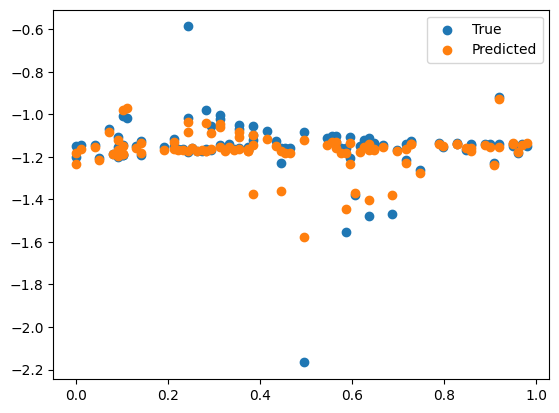

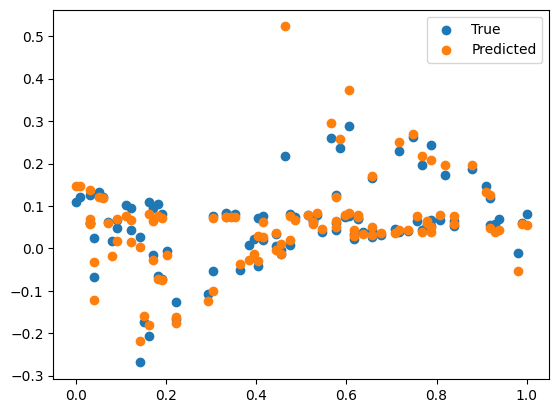

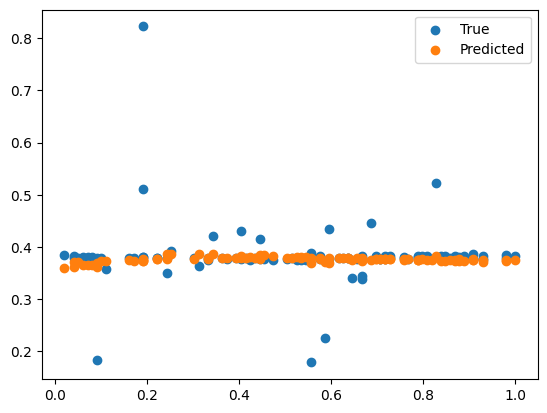

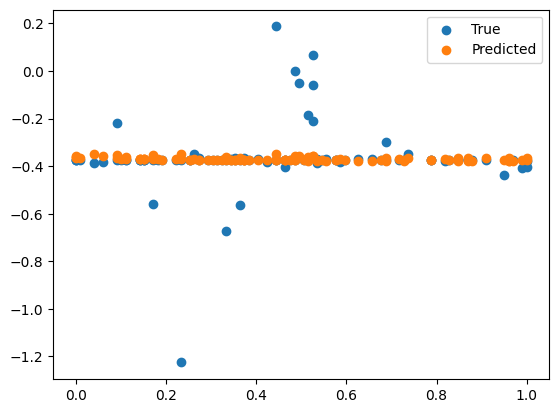

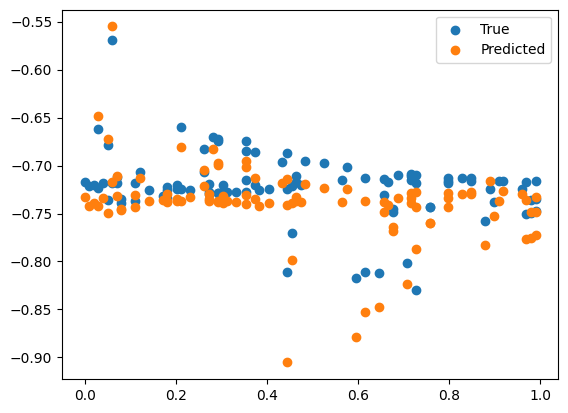

In [30]:
test_u, test_y, test_Guy = next(iter(test_loader))
pred_Guy = onet(test_u, test_y).detach().numpy()

for i in range(5):
    plt.figure()
    plt.scatter(test_y[i, :, 0], test_Guy[i, :, 0], label="True")
    plt.scatter(test_y[i, :, 0], pred_Guy[i, :, 0], label="Predicted")
    plt.legend()
    plt.show()

The final step is to visualize the performance of the trained DeepONet. The code loads the best-performing model and uses it to predict the solution for a sample from the test set. The predicted solution is then plotted against the ground truth solution. The plot shows the initial condition, the true solution, and the DeepONet's prediction at a specific time point. This visualization provides a qualitative assessment of the model's accuracy.